# Discretization

The aim of the notebook is to evaluate the performance of CategoricalHMM on discretized data

In [1]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import multivariate_normal
from source.model.discretized_HMM import DiscreteHMM

In [2]:
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
# sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
# https://hmmlearn.readthedocs.io/en/latest/tutorial.html

np.random.seed(42)

model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])

model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))

model.sample(1)

(array([[-1.11188012,  0.31890218]]), array([0]))

In [4]:
norm1 = multivariate_normal(model.means_[0], model.covars_[0])
norm2 = multivariate_normal(model.means_[1], model.covars_[1])
norm3 = multivariate_normal(model.means_[2], model.covars_[2])

In [5]:
sample_sizes = [100, 1000, 10000, 100000]
nodes_numbers = [3, 5, 10, 25, 50, 100]

In [6]:
def acc(myHMM, Xd, Z):
    return (myHMM.predict(Xd) == Z).mean()

In [7]:
sample_size = sample_sizes[0]
X, Z = model.sample(sample_size)
ll_target = model.score(X)

myHMM1 = DiscreteHMM('random', 10, 3)
myHMM2 = DiscreteHMM('uniform', 10, 3)
myHMM3 = DiscreteHMM('latin_cube_u', 10, 3)
myHMM4 = DiscreteHMM('latin_cube_q', 10, 3)

myHMM1.fit(X)
myHMM2.fit(X)
myHMM3.fit(X)
myHMM4.fit(X)

Xd1 = myHMM1._discretize(X, False)
Xd2 = myHMM2._discretize(X, False)
Xd3 = myHMM3._discretize(X, False)
Xd4 = myHMM4._discretize(X, False)

ll_1 = myHMM1.score(Xd1)
ll_2 = myHMM2.score(Xd2)
ll_3 = myHMM3.score(Xd3)
ll_4 = myHMM4.score(Xd3)

print(ll_target, ll_1, ll_2, ll_3, ll_4)

print(myHMM1.n_features, myHMM2.n_features, myHMM3.n_features, myHMM4.n_features)

print(acc(myHMM1, Xd1, Z), acc(myHMM2, Xd2, Z), acc(myHMM3, Xd3, Z), acc(myHMM4, Xd4, Z))

Nodes had been set previously. Use force=True to update them
Nodes had been set previously. Use force=True to update them
Nodes had been set previously. Use force=True to update them
Nodes had been set previously. Use force=True to update them
-365.4702752166337 -187.0168568940522 -92.18439587804141 -70.20452366059993 -209.76676765227467
10 9 8 10
0.42 0.5 0.3 0.23


Text(0.5, 1.0, 'Observation Distributions')

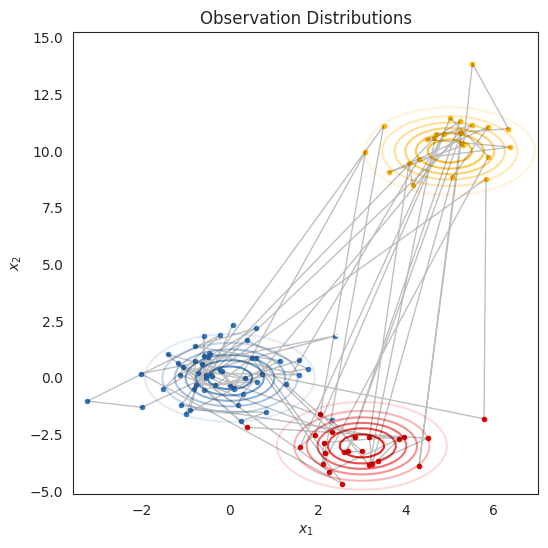

In [21]:
x1, y1 = X.min(axis=0) * 1.1
x2, y2 = X.max(axis=0) * 1.1

XX, YY = np.meshgrid(np.linspace(x1, x2, 100), np.linspace(y1, y2, 100))
data = np.column_stack((XX.ravel(), YY.ravel()))
input = np.zeros((data.shape[0], 0))
mask = np.ones_like(data, dtype=bool)
tag = None
lls = np.concatenate([norm1.pdf(data).reshape(-1, 1), norm2.pdf(data).reshape(-1, 1), norm3.pdf(data).reshape(-1, 1)], axis=1)

plt.figure(figsize=(6, 6))
for k in range(3):
    plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    plt.plot(X[Z==k, 0], X[Z==k, 1], 'o', mfc=colors[k], mec='none', ms=4)

plt.plot(X[:,0], X[:,1], '-k', lw=1, alpha=.25)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Observation Distributions")